In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
%cd /content/gdrive/MyDrive/transfer

/content/gdrive/MyDrive/transfer


In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [74]:
 batch_size= 16
learning_rate = 0.0001
epoch = 30

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

In [75]:
img_dir ="/content/gdrive/MyDrive/transfer/snake/train" 
train_data = dset.ImageFolder(img_dir, transforms.Compose([      
            # ①(512)③②RCrop  <-- Best !!
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

38


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [76]:
# 2. Dev data
img_dir = "/content/gdrive/MyDrive/transfer/snake/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)


# 3. Test data
img_dir = "/content/gdrive/MyDrive/transfer/snake/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)#클래스 개수
print(train_data.classes)#클래스 종류
print(train_data.class_to_idx)#train index
print(train_data.__len__())#train 길이

print("Training: %d, Dev: %d, Test: %d," %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)
# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 2
['anaconda', 'python']
{'anaconda': 0, 'python': 1}
38
Training: 38, Dev: 22, Test: 30,
['anaconda', 'python']
['anaconda', 'python']
['anaconda', 'python']


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [77]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#     print("yhk[%d]" %cnt),
#     print(i)
#     cnt = cnt+1

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [78]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = self.layer0(x)
        #print(out.size())
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

In [79]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True
    

# fc_layer = MyFullyConn().cuda()
# cnt = 0
# for param in fc_layer.parameters():
#     print("[%d]" %cnt),
#     print(param.requires_grad)
#     cnt = cnt+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [80]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

In [81]:
import utils

total_time = 0
disp_step = 10#10번마다 저장하기 위해 내가 임의로선언

to_train = True
if (to_train==False):
    #netname = './nets/media_vgg19_fixed.pkl'
    #netname = './nets/media_vgg19_RCrop_fixed.pkl'
    netname =  '/content/gdrive/MyDrive/transfer/nets_29'
    model = torch.load(netname)
else:   
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = '/content/gdrive/MyDrive/transfer/nets'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 47.37, dev: 45.45, test: 50.00
0..

[0/30] loss: 0.725, 
Correct of train: 47.37, dev: 45.45, test: 50.00, 
time: 1.73 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/30] loss: 0.664, 
Correct of train: 89.47, dev: 95.45, test: 90.00, 
time: 21.26 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..
20..

[20/30] loss: 0.682, 
Correct of train: 94.74, dev: 95.45, test: 90.00, 
time: 40.70 sec..
21..
22..
23..
24..
25..
26..
27..
28..
29..

[29/30] loss: 0.580, 
Correct of train: 100.00, dev: 95.45, test: 83.33, 
time: 58.10 sec..
Total time: 58.10 sec


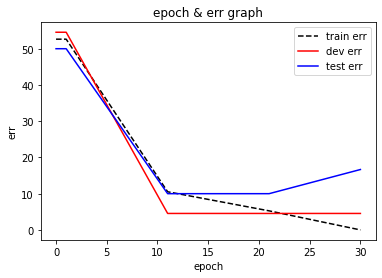

In [82]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


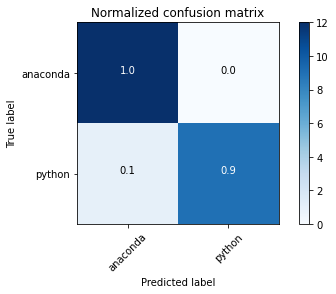

Confusion matrix, without normalization


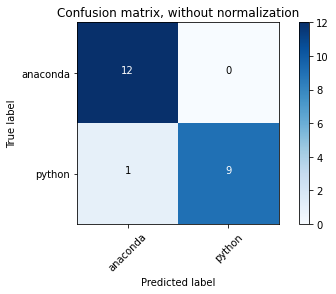

	 acc  |	 pre  |	 rec  |	 f1
 anaconda: 0.95 |	 0.92 |	 1.00 |	 0.96
 python: 0.95 |	 1.00 |	 0.90 |	 0.95
*accuracy: 0.95, precision: 0.96, recall: 0.95, *f1 score: 0.95
[AP]
anaconda: 0.97
python: 0.97

[mAP] 0.971
[miAP] 0.977


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.52448404, 0.99248409, 0.80233628, 0.95675254, 0.99376953,
        0.90580356, 0.83700973, 0.6191175 , 0.98058385, 0.87553096,
        0.77015948, 0.68521577, 0.95331073, 0.95017081, 0.77438289,
        0.90841335, 0.9996146 , 0.9996146 , 0.99970311, 0.99971259,
        0.99836838, 0.97953361]))

In [83]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


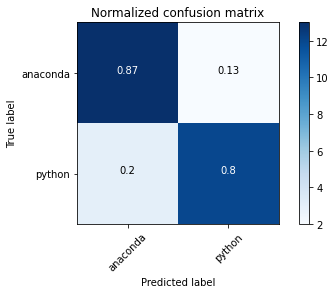

Confusion matrix, without normalization


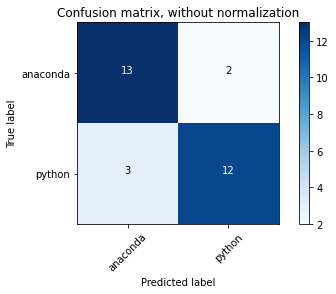

	 acc  |	 pre  |	 rec  |	 f1
 anaconda: 0.83 |	 0.81 |	 0.87 |	 0.84
 python: 0.83 |	 0.86 |	 0.80 |	 0.83
*accuracy: 0.83, precision: 0.83, recall: 0.83, *f1 score: 0.83
[AP]
anaconda: 0.94
python: 0.95

[mAP] 0.948
[miAP] 0.917


In [84]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: anaconda
 True predicted images/total anaconda category: 13 / 15
Predicted probability:
[0.9858668  0.01413319]


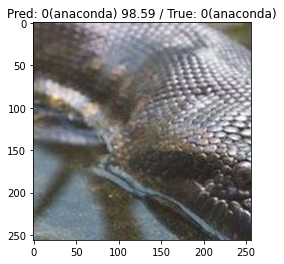

Predicted probability:
[0.8968699  0.10313011]


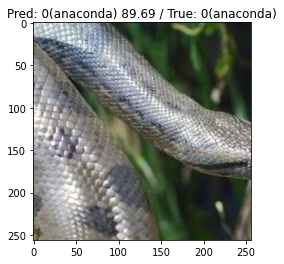

Predicted probability:
[0.940078   0.05992199]


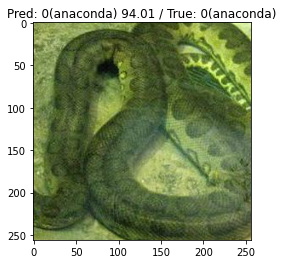

Predicted probability:
[0.96563905 0.03436093]


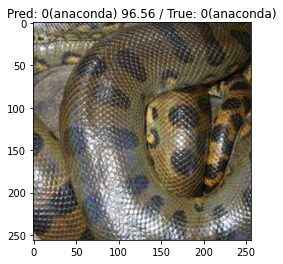

Predicted probability:
[0.6994662  0.30053377]


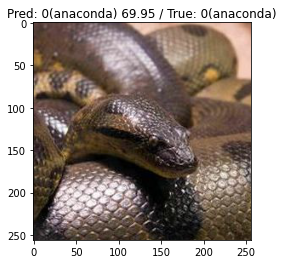

Predicted probability:
[0.52296543 0.47703457]


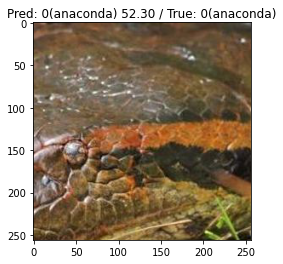

 False predicted images/total anaconda category: 2 / 15
Predicted probability:
[0.4436049 0.5563951]


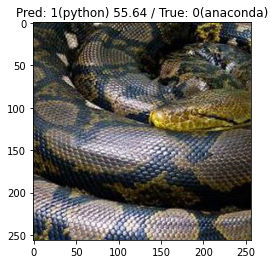

Predicted probability:
[0.44232476 0.55767524]


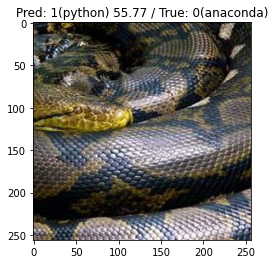

Category: python
 True predicted images/total python category: 12 / 15
Predicted probability:
[0.00570482 0.9942952 ]


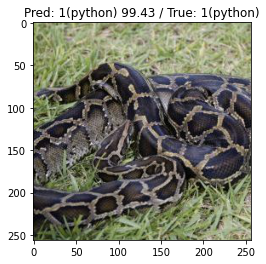

Predicted probability:
[0.03934069 0.9606593 ]


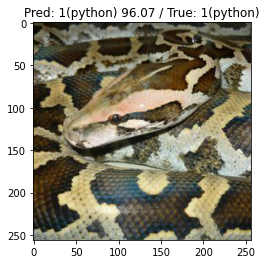

Predicted probability:
[0.00288265 0.99711734]


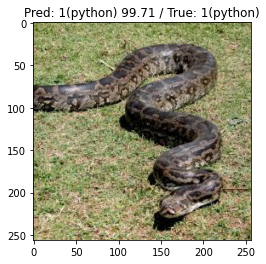

Predicted probability:
[0.10553999 0.89446   ]


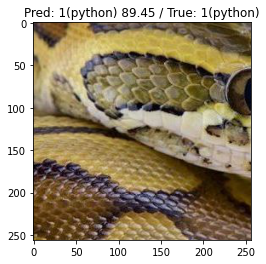

Predicted probability:
[0.02858692 0.9714131 ]


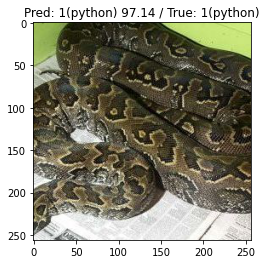

Predicted probability:
[0.00622142 0.9937786 ]


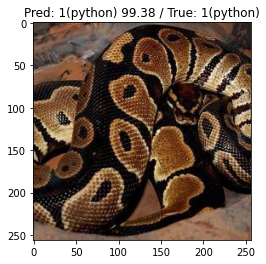

 False predicted images/total python category: 3 / 15
Predicted probability:
[0.81102    0.18898001]


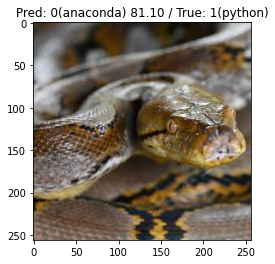

Predicted probability:
[0.54560846 0.45439157]


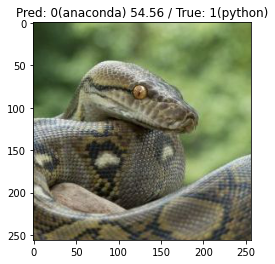

Predicted probability:
[0.6672295  0.33277053]


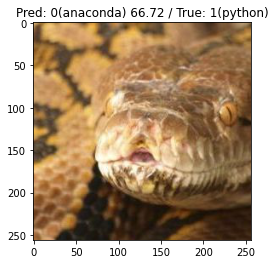

In [85]:
utils.VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=6)